<a href="https://colab.research.google.com/github/ethan-ghoreishi/stock-market-prediction/blob/master/stock_market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from datetime import datetime
from datetime import datetime
import numpy as np

In [103]:
# Read the data and change the date column to datetime objects
df = pd.read_csv("sphist.csv")
df["Date"] = pd.to_datetime(df["Date"])
# Sort by date from oldest to newest
df_sorted = df.sort_values("Date", ascending=True).copy()

df_sorted.head()
# Another approach for changing the date column
# def convert_date(x):
#     return dt.strptime(x, "%Y-%M-%d")

# strp_date = df["Date"].apply(convert_date)

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


In [112]:
# Add indicators that could be helpful for machine learning
# Rolling mean will use the current day's price, therefore reindex (shift(-1))
# Average/std price of the past 5, 30, 365 days
def generate_indicator(col, window, func="mean", shift=True):
  try:
    if func.lower() == "mean":
      rolling_result = df[col].rolling(window).mean()
    if func.lower() == "std":
      rolling_result = df[col].rolling(window).std()
    if func.lower() == "sum":
      rolling_result = df[col].rolling(window).mean()
  except:
      print("Please input a valid function")
  if shift:
    return rolling_result.shift(-1)
  
  return rolling_result

for c in ["Open", "Close", "Volume", "High", "Low"]:
  for w in [5, 30, 365]:
    for f in ["mean", "std"]:
      name = f.capitalize() + " " + str(w) + " Days " + c
      df_sorted[name] = generate_indicator(c, w, f)

df_sorted["Mean 5/30 Days High"] = df_sorted["Mean 5 Days High"]/df_sorted["Mean 30 Days High"]
df_sorted["Mean 5/30 Days Low"] = df_sorted["Mean 5 Days Low"]/df_sorted["Mean 30 Days Low"]
df_sorted["Mean 5/30 Days Volume"] = df_sorted["Mean 5 Days Volume"]/df_sorted["Mean 30 Days Volume"]

# Some indicators require year of historical data to compute (1951-01-03 onward)
start_date = df_sorted["Date"] >= datetime(year=1951, month=1, day=3)

# Remove any rows from the DataFrame that fall before 1951-01-03
df_sorted = df_sorted[start_date]
df_sorted.dropna(axis=0, inplace=True)
df_sorted.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Mean 5 Days Open,Std 5 Days Open,Mean 30 Days Open,Std 30 Days Open,Mean 365 Days Open,Std 365 Days Open,Mean 5 Days Close,Std 5 Days Close,Mean 30 Days Close,Std 30 Days Close,Mean 365 Days Close,Std 365 Days Close,Mean 5 Days Volume,Std 5 Days Volume,Mean 30 Days Volume,Std 30 Days Volume,Mean 365 Days Volume,Std 365 Days Volume,Mean 5 Days High,Std 5 Days High,Mean 30 Days High,Std 30 Days High,Mean 365 Days High,Std 365 Days High,Mean 5 Days Low,Std 5 Days Low,Mean 30 Days Low,Std 30 Days Low,Mean 365 Days Low,Std 365 Days Low,Mean 5/30 Days High,Mean 5/30 Days Low,Mean 5/30 Days Volume,year_label,month_label,day_label
16339,1951-01-03,20.690001,20.690001,20.690001,20.690001,3370000.0,20.690001,20.840001,0.117047,21.432667,0.466468,22.814521,1.017104,20.840001,0.117047,21.432667,0.466468,22.814521,1.017104,3192000.0,276622.483656,2.832333e+06,560847.174252,1.583041e+06,681765.657914,20.840001,0.117047,21.432667,0.466468,22.814521,1.017104,20.840001,0.117047,21.432667,0.466468,22.814521,1.017104,0.972348,0.972348,1.126986,1951,1,3
16338,1951-01-04,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,20.910001,0.161090,21.477667,0.465452,22.824548,1.014932,20.910001,0.161090,21.477667,0.465452,22.824548,1.014932,3346000.0,364321.284671,2.799667e+06,577237.685854,1.578219e+06,677715.587862,20.910001,0.161090,21.477667,0.465452,22.824548,1.014932,20.910001,0.161090,21.477667,0.465452,22.824548,1.014932,0.973569,0.973569,1.195142,1951,1,4
16337,1951-01-05,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,20.942001,0.116060,21.521334,0.450209,22.835014,1.012553,20.942001,0.116060,21.521334,0.450209,22.835014,1.012553,3326000.0,365417.567262,2.744000e+06,600399.877279,1.572603e+06,671289.780975,20.942001,0.116060,21.521334,0.450209,22.835014,1.012553,20.942001,0.116060,21.521334,0.450209,22.835014,1.012553,0.973081,0.973081,1.212099,1951,1,5
16336,1951-01-08,21.000000,21.000000,21.000000,21.000000,2780000.0,21.000000,21.006001,0.149767,21.563333,0.446104,22.845206,1.011441,21.006001,0.149767,21.563333,0.446104,22.845206,1.011441,3346000.0,372464.761372,2.693000e+06,608560.493876,1.566575e+06,664771.920062,21.006001,0.149767,21.563333,0.446104,22.845206,1.011441,21.006001,0.149767,21.563333,0.446104,22.845206,1.011441,0.974154,0.974154,1.242481,1951,1,8
16335,1951-01-09,21.120001,21.120001,21.120001,21.120001,3800000.0,21.120001,21.054001,0.132779,21.595333,0.428749,22.855315,1.010084,21.054001,0.132778,21.595333,0.428749,22.855315,1.010084,3258000.0,409597.361398,2.643667e+06,610096.008079,1.560575e+06,658118.907883,21.054001,0.132778,21.595333,0.428749,22.855315,1.010084,21.054001,0.132778,21.595333,0.428749,22.855315,1.010084,0.974933,0.974933,1.232379,1951,1,9


In [0]:
# Find the columns that are highly correlated with the output
close_corr = df_sorted.corr()["Close"].abs().sort_values(ascending=False)
high_corr = list(close_corr[close_corr >= .3].index)

# Remove columns that inject future knowledge
# future_knowledge_cols = ["Close", "High", "Low", "Open", "Volume", "Adj Close"]
# for col in future_knowledge_cols:
#     high_corr.remove(col)

In [0]:
# Create correlation matrix
corr_matrix = df_sorted[high_corr].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
df_indicators = df_sorted[high_corr].drop(df_sorted[to_drop], axis=1)

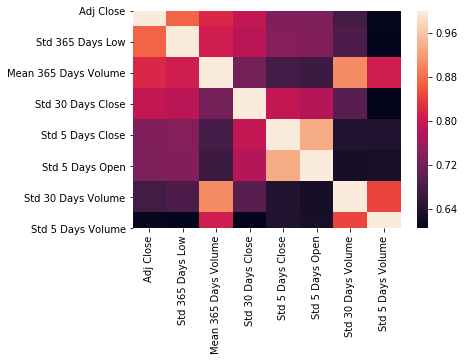

In [107]:
import seaborn as sns
%matplotlib inline

sns.heatmap(df_indicators.corr())

In [0]:
# Add the year component of the date
df_sorted["year_label"] = df["Date"].apply(lambda x: datetime.strftime(x, "%Y"))
df_sorted["month_label"] = df["Date"].apply(lambda x: int(datetime.strftime(x, "%m")))
df_sorted["day_label"] = df["Date"].apply(lambda x: int(datetime.strftime(x, "%d")))

In [0]:
train_end_date = df["Date"] < datetime(year=2013, month=1, day=1)
test_start_date = df["Date"] >= datetime(year=2013, month=1, day=1)

train = df[train_end_date]
test = df[test_start_date]
train_target = train["Close"]
test_target = test["Close"]

# remove columns that inject future knowledge
predictors = list(train.columns)
future_knowledge_cols = ["Close", "High", "Low", "Open", "Volume", "Adj Close", "Date"]
for col in future_knowledge_cols:
    predictors.remove(col)

### Error Metric
Use MAE to show how "close" we are to the price in intuitive terms

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[predictors], train_target)
lr_train_predictions = lr.predict(train[predictors])
lr_test_predictions = lr.predict(test[predictors])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [0]:
print(mean_absolute_error(train_target, lr_train_predictions))
print(mean_absolute_error(test_target, lr_test_predictions))

2.273771072337667
6.955570908236561


In [0]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(min_samples_leaf=5)
rf.fit(train[predictors], train_target)
rf_train_predictions = rf.predict(train[predictors])
rf_test_predictions = rf.predict(test[predictors])

In [0]:
# rf overfitting due to the small dataset
print(mean_absolute_error(train_target,rf_train_predictions))
print(mean_absolute_error(test_target,rf_test_predictions))

1.7497170058800895
330.56019965925344


In [0]:
import keras
from keras import layers

def build_model():
    model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train[predictors].keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
  ])

    optimizer = keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

Using TensorFlow backend.


In [0]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2432      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 27,265
Trainable params: 27,265
Non-trainable params: 0
_________________________________________________________________


In [0]:
example_batch = train[predictors][:10]
example_result = model.predict(example_batch)
example_result

array([[132720.14 ],
       [129898.945],
       [130784.21 ],
       [125337.56 ],
       [124342.22 ],
       [161453.27 ],
       [164678.16 ],
       [169755.03 ],
       [184184.11 ],
       [189447.06 ]], dtype=float32)

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 100

history = model.fit(
  train[predictors], train_target,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


.....

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,93902.891667,210.938276,93902.891667,1.194041e+13,215223.461925,1.194041e+13,0
1,93909.577585,209.972323,93909.577585,1.192214e+13,215060.412725,1.192214e+13,1
2,93905.564196,210.237281,93905.564196,1.193223e+13,215150.489809,1.193223e+13,2
3,93905.534736,210.312423,93905.534736,1.195304e+13,215336.056621,1.195304e+13,3
4,93904.725726,210.419885,93904.725726,1.195828e+13,215382.767723,1.195828e+13,4


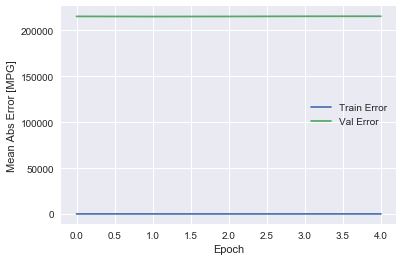

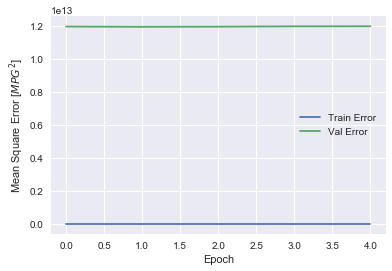

In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#     plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#     plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)

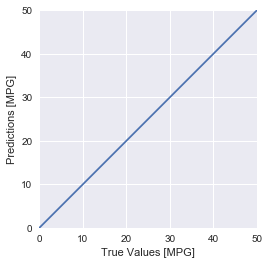

In [0]:
nn_test_predictions = model.predict(test[predictors]).flatten()
nn_train_predictions = model.predict(train[predictors]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_target, nn_test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [0]:
print(mean_absolute_error(train_target, nn_train_predictions))
print(mean_absolute_error(test_target, nn_test_predictions))

43250.42878999707
1639.2396120969997


In [0]:
21